# Imports

In [45]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

import glob

# Question 1

## Question a)

The single strip can be seen as a 1D lattice with a two-atom basis, where atoms of type $A$ are in the lower row and atoms of type $B$ are in the upper row.

We can impose periodic boundary conditions by setting $\ket{n, X} = \ket{n+N, X}$ for $X = A, B$:

The Hamiltonian for a system with $N$ unit cells can be written as:

$$
\begin{align*}

H &= \sum_{n=0}^{N} -\frac{\Delta}{2}\ket{n, A} \bra{n, A} + \frac{\Delta}{2}\ket{n, B} \bra{n, B}
\\[0.5cm]

&\quad + t_0(\ket{n, A}\bra{n+1, A} + \ket{n+1, A}\bra{n, A} + \ket{n, B}\bra{n+1, B} + \ket{n+1, B}\bra{n, B})
\\[0.5cm]

&\quad+ t_1(\ket{n, A}\bra{n, B} + \ket{n, B}\bra{n, A} + \ket{n, A}\bra{n-1, B} + \ket{n-1, B}\bra{n, A})
\\[0.5cm]

&\quad+ t_2(\ket{n, A}\bra{n+1, B} + \ket{n+1, B}\bra{n, A})

\end{align*}
$$

Applying Bloch's theorem we obtain a tight-binding matrix of the form:

$$
\begin{align*}

t^{AA}(\textbf k) &= -\frac{\Delta}{2} + t_0e^{i \textbf k \cdot \textbf a_0} + t_0e^{-i \textbf k \cdot \textbf a_0}
\\[0.2cm]

&= -\frac{\Delta}{2} + 2t_0\cos(\textbf k \cdot \textbf a_0)
\\[0.5cm]

t^{BB}(\textbf k) &= +\frac{\Delta}{2} + t_0e^{i \textbf k \cdot \textbf a_0} + t_0e^{-i \textbf k \cdot \textbf a_0}
\\[0.2cm]

&= +\frac{\Delta}{2} + 2t_0 \cos(\textbf k \cdot \textbf a_0)

\\[0.5cm]

t^{AB}(\textbf k) &= t_1 + t_1e^{- i \textbf k \cdot \textbf a_0} + t_2 e^{i \textbf k \cdot \textbf a_0}

\end{align*}
$$

Where $\textbf k \cdot \textbf a_0 = ka$ and $k$ has the form, for $m = 0, 1, \dots, N-1$:
$$
k = \frac{2\pi}{a} \cdot \frac{m}{N}
$$

We can use the following notation:

$$
H_k = 
\begin{pmatrix}
t^{AA}(k) & t^{AB}(k)
\\[0.5cm]

[t^{AB}(k)]^* & t^{BB}(k)
\end{pmatrix}
$$

### Diagonalization

We have that, letting $\lambda_1$ and $\lambda_2$ be the eigenvalues of this matrix:

$$
\begin{align*}

\lambda_1 + \lambda_2 &= \text{Tr}(H_k)
\\[0.2cm]

&= 4 t_0 \cos(ka)
\\[0.5cm]

\lambda_1 \times \lambda_2 &= \det(H_k)
\\[0.2cm]

&= \left(-\frac{\Delta}{2} + 2t_0\cos(ka)\right)\left(\frac{\Delta}{2} + 2t_0\cos(ka)\right) - |t^{AB}(k)|^2
\\[0.4cm]

&= 4 t_0^2 \cos^2(ka) - \frac{\Delta^2}{4} - |t^{AB}(k)|^2

\end{align*}
$$

Which corresponds to the following bands:

$$
\begin{align*}

E_\pm(k) = 2 t_0 \cos(ka) \pm \sqrt{\frac{\Delta^2}{4} + |t^{AB}(k)|^2}

\end{align*}
$$

### Units

In the code bellow we use units where $t = 1$ and $a = 1$.

## Question b)

For a chosen number of cells $N$ we evaluate the bands at the $N$ allowed $k$ points defined above, and for each of them we add to the total DOS an approximation to the Dirac delta with width $\gamma$ which we call $\delta_\gamma$ centered at energies $E_\pm(k)$:

$$
\begin{align*}

\rho(\varepsilon) = \frac1N\sum_{m=0}^{N-1}\sum_{\lambda = \pm}\delta_\gamma\left(\varepsilon - E_\lambda\left(2\pi \times \frac mN\right)\right)

\end{align*}
$$

To comput this in C++ with OpenMP we use trivial parallelization, which means that we separate the $m$ values among different threads and each thread computes a part of the sum. At the end we sum the partial results from all threads and divide by the normalization constant.

### Python DOS

We compute the DOS with Python to check against our C++ code in later exercises.

In [46]:
# Nascent Delta
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))


def common(kk):
    return -2 * np.cos(kk)


def diff(kk, Delta, t1, t2):
    tab2 = np.abs(t1 + t1 * np.exp(-1j * kk) + t2 * np.exp(1j * kk))**2
    return np.sqrt(Delta ** 2 / 4 + tab2)


# Compute the DOS in the thermodynamic limit
def dosThermo1D(ee, Delta, Nk = 2500, sigma = 0.04, t1 = 0.5, t2 = 0.25):
    # We evaluate points within the FBZ
    kk = np.linspace(-np.pi, np.pi, Nk)

    # Evaluate bands
    cc = common(kk)
    dd = np.real(diff(kk, Delta, t1, t2))
    bb = list(cc+dd) + list(cc-dd)
    
    # Calculate DOS
    dataExact = np.zeros_like(ee)
    for energy in bb:
        dataExact += gaussian(ee, energy, sigma)
    
    return dataExact / Nk


ee = np.linspace(-4, 4, 1000)
dosThermoArri = dosThermo1D(ee, 1)
dosThermoArrii = dosThermo1D(ee, 0.50)
dosThermoArriii = dosThermo1D(ee, 0.25)

### C++ DOS

In [47]:
# Find all text files starting with "out"
fileListData = glob.glob("out1*.txt")

# Organize the data into arrays
dataArr1 = []
for file in fileListData:
    _, tnum, Delta, N, gam = file.split("-")
    tnum, Delta, N, gam = int(tnum), float(Delta), int(N), float(gam[:-4])
    
    # Load the file as an array of strings
    data = np.loadtxt(file)
    dataArr1 += [(tnum, Delta, N, gam, data)]

In [48]:
def plotAll(dataArr: list, cols: int) -> None:
    # Needed number of columns
    rows = len(dataArr) // cols + 1

    plt.figure(figsize=(cols * 6, rows * 4))
    for index, item in enumerate(dataArr):
        # Getting data
        tnum, Delta, N, gam, data = item
        data = data.T
        dosThermoArr = dosThermo1D(data[0, :], Delta)

        # Plotting
        plt.subplot(rows, cols, index+1)
        plt.title(f"Density of States for $N$ = {N}, $\\Delta$ = {Delta}, $\\gamma$ = {gam}")
        plt.plot(data[0, :], data[1, :], label="C++ DOS")
        plt.plot(data[0, :], dosThermoArr, label="Python DOS")
        plt.xlabel("$\\varepsilon / t$")
        plt.ylabel("$\\rho(\\varepsilon) \\times t$")
        plt.legend()

        # Analysis
        print(f"Analysis for N = {N}, Delta = {Delta}, gamma = {gam}")
        print(f"Average difference is {np.mean(data[1, :] - dosThermoArr)}")
        print(f"Average absolute difference is {np.mean(np.abs(data[1, :] - dosThermoArr))}")
        print(f"Maximum absolute difference is {np.max(np.abs(data[1, :] - dosThermoArr))}")
        print("\n\n")    

    plt.subplots_adjust(hspace=0.35)
    plt.show()

Analysis for N = 100000, Delta = 0.25, gamma = 0.01
Average difference is -0.0005112132490093581
Average absolute difference is 0.01674045249486678
Maximum absolute difference is 0.6896260081014405



Analysis for N = 100000, Delta = 0.5, gamma = 0.01
Average difference is -0.0005151381418779963
Average absolute difference is 0.01672424328790301
Maximum absolute difference is 0.676768624952697



Analysis for N = 100000, Delta = 1.0, gamma = 0.01
Average difference is -0.0005318608017436733
Average absolute difference is 0.01666981243352148
Maximum absolute difference is 0.678666781739607





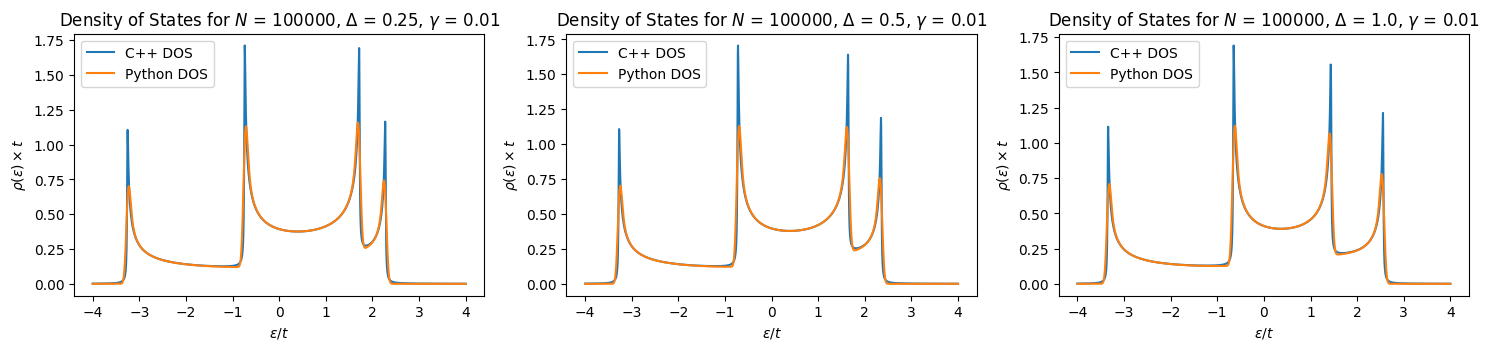

In [49]:
plotAll(dataArr1, 3)

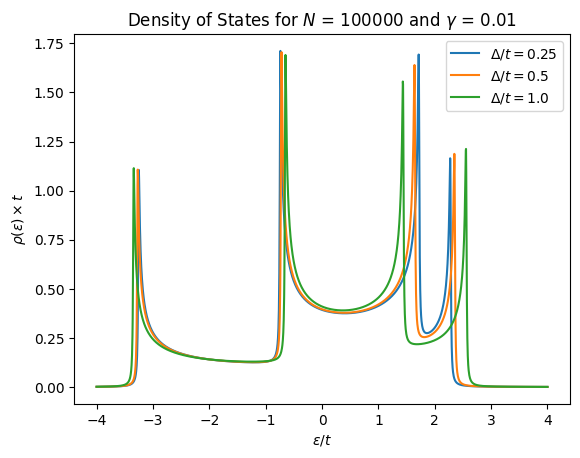

In [50]:
# View all C++ DOS overlapped
for item in dataArr1:
    tnum, Delta, N, gam, data = item
    data = data.T

    plt.plot(data[0, :], data[1, :], label=f"$\\Delta/t = {Delta}$")

plt.title(f"Density of States for $N$ = {N} and $\\gamma$ = {gam}")
plt.legend()
plt.xlabel("$\\varepsilon / t$")
plt.ylabel("$\\rho(\\varepsilon) \\times t$")
plt.show()

### Parallelization

We simply divide the energies at which we have to place a Dirac delta among the available threads.

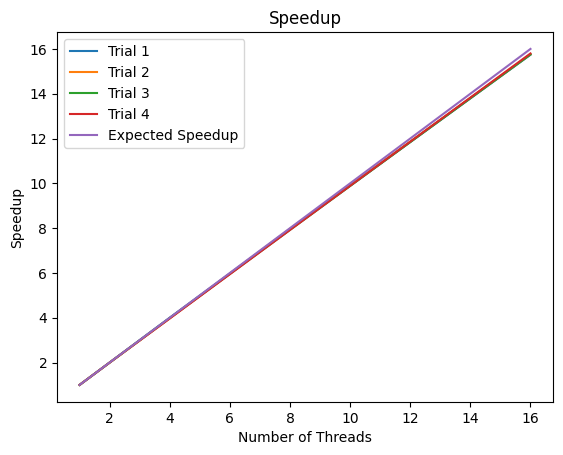

In [51]:
# Find all text files starting with "time"
fileListTime = glob.glob("time1*.txt")

# Get time data
ttArr, rrArr, uuArr = [], [], []
for fileName in fileListTime:
    with open(fileName, "r") as file:
        text = file.read().split("\n")
        text = [item for item in text if len(item) > 2]

    tt, rr, uu = [], [], []

    # Timing itself
    for item in text:
        item = item.split()
        tt += [int(item[5][:-1])]
        rr += [float(item[6])]

    ttArr += [tt]
    rrArr += [rr]
    uuArr += [uu]

ttArr = np.array(ttArr)
rrArr = np.array(rrArr)
uuArr = np.array(uuArr)

plt.title(f"Speedup")
for tt, rr, index in zip(ttArr, rrArr, range(0, len(ttArr))):
    plt.plot(tt, rr[0] / rr, label=f"Trial {index+1}")

plt.plot(tt, tt, label="Expected Speedup")
plt.xlabel("Number of Threads")
plt.ylabel("Speedup")
plt.legend()

# Question 2

We apply twisted boundary conditions to this system, with ($\gamma$ is once again the width of the nascent delta used):
- $L$ as the size of the super cell.
- $K$ as the number of samples over $k$-space to get the system's DOS.
- $R$ as the number of averages over disorder.

## No Noise

First we run a simulation without noise to make sure our coding is working as intended.

In [52]:
# Find all text files starting with "out"
fileListData = glob.glob("out2*.txt")

# Organize the data into arrays
dataArr2 = []
dataDict2 = dict()
for file in fileListData:
    _, L, K, w, gam, R = file.split("-")
    L, K, w, gam, R = int(L), int(K), float(w), float(gam), float(R[:-4])
    
    # Load the file as an array of strings
    data = np.loadtxt(file)
    if w == 0:
        dataArr2 += [(L, K, w, gam, R, data)]
    else:
        dataDict2[w] = dataDict2.get(w, []) + [(L, K, gam, R, data)]

In [53]:
def plotAll(dataArr: list, cols: int) -> None:
    # Needed number of columns
    rows = len(dataArr) // cols + 1

    plt.figure(figsize=(cols * 6, rows * 4))
    for index, item in enumerate(dataArr):
        # Getting data
        L, K, w, gam, R, data = item
        dosThermoArr = dosThermo1D(data[0, :], 0.5, t1=0.5, t2=0.25)

        # Plotting
        plt.subplot(rows, cols, index+1)
        plt.title(f"DOS for $L$ = {L}, $K$ = {K}, $w$ = {w}, $R$ = {R} and $\\gamma$ = {gam}")
        plt.plot(data[0, :], data[1, :], label="Calculated DOS")
        plt.plot(data[0, :], dosThermoArr, label="Thermodynamic DOS")
        plt.xlabel("$\\varepsilon / t$")
        plt.ylabel("$\\rho(\\varepsilon) \\times t$")
        plt.legend()

        # Analysis
        print(f"Analysis for L = {L}, K = {K}, w = {w}, $R$ = {R} and gam = {gam}")
        print(f"Average difference is {np.mean(data[1, :] - dosThermoArr)}")
        print(f"Average absolute difference is {np.mean(np.abs(data[1, :] - dosThermoArr))}")
        print(f"Maximum absolute difference is {np.max(np.abs(data[1, :] - dosThermoArr))}")
        print("\n\n")    

    plt.subplots_adjust(hspace=0.35)
    plt.show()

Analysis for L = 100, K = 5, w = 0.0, $R$ = 32.0 and gam = 0.05
Average difference is -0.0019830387362150524
Average absolute difference is 0.023285846877331182
Maximum absolute difference is 0.29523273632755065





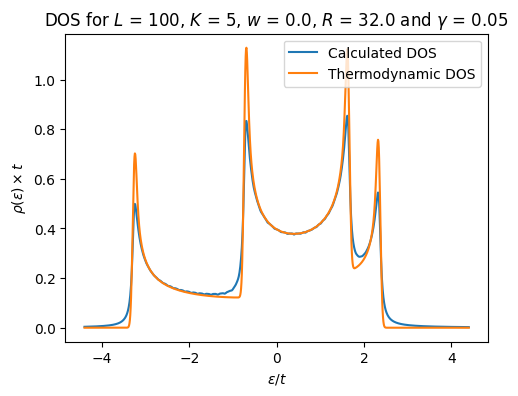

In [54]:
plotAll(dataArr2, 2)

## Noise

We can now see the effects of noise:

- We see that the DOS is getting broader with increased noise, due to the increased variation in local energies.

- Also, as noise increases, and especially beyond $\text w = 1$, most of the structure of the system breaks down, meaning that the DOS becomes dominated by noise.

- Moreover, we see that, especially bellow $\text w = 1$ that decreasing super cell size creates lower-frequency behavior in the DOS. This may be a consequence of the fact that in our implementation the noise is periodic with spatial period equal to the size of the super cell, hence lower super cell dimension corresponds to shorter-period noise, which creates some structure that allows for larger fluctuations of the DOS.

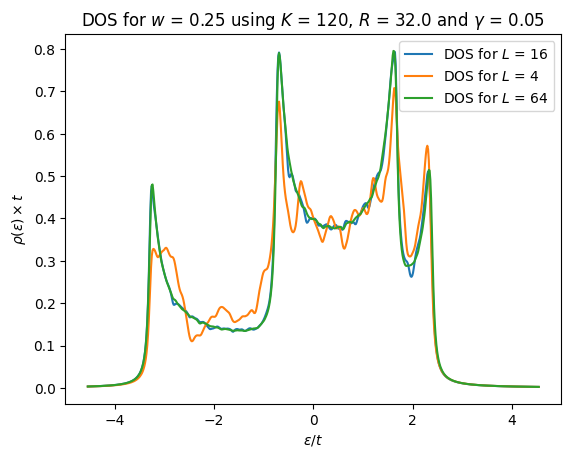

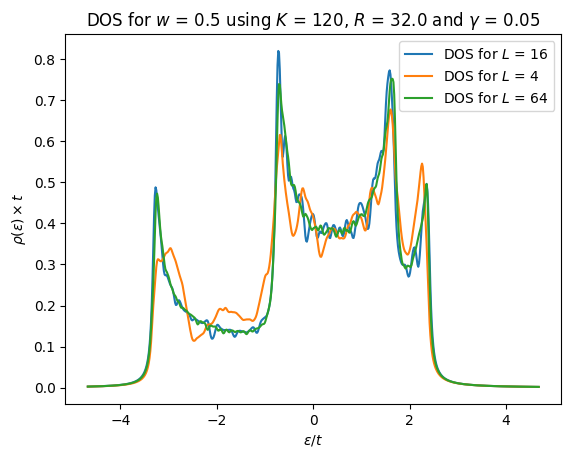

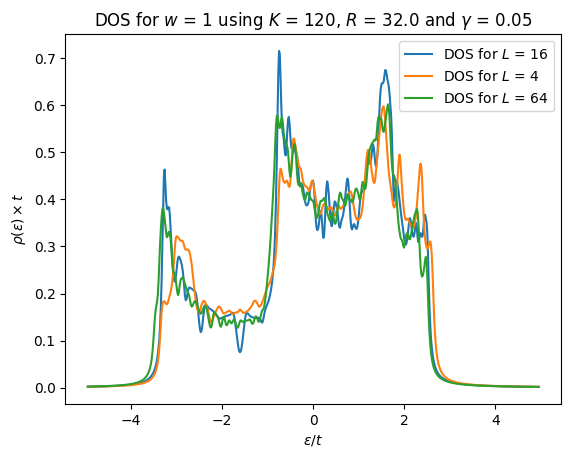

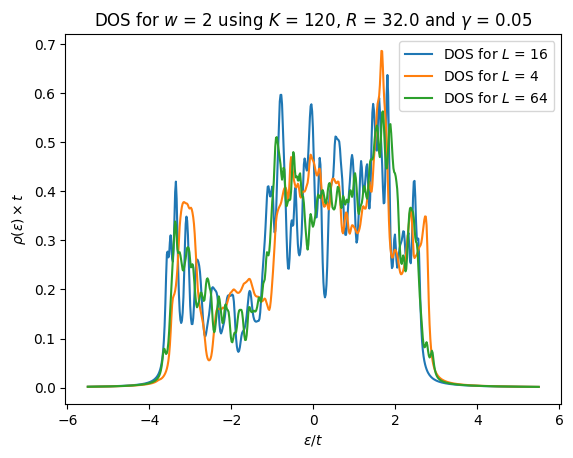

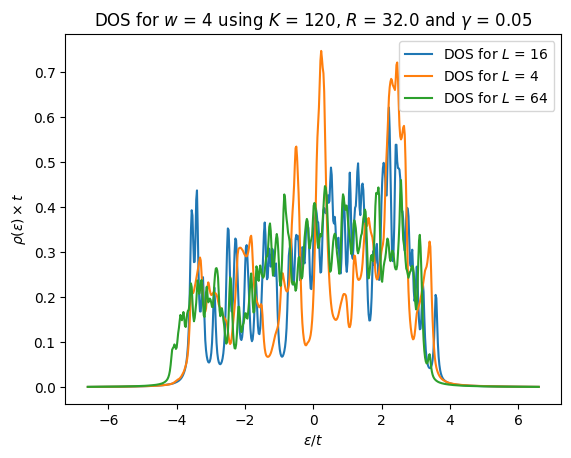

In [55]:
# Plot the system for fixed noise with different super cell dimensions
for w in [0.25, 0.5, 1, 2, 4]:
    dataArrLocal = dataDict2[w]

    for item in dataArrLocal:
        L, K, gam, R, data = item
        plt.title(f"DOS for $w$ = {w} using $K$ = {K}, $R$ = {R} and $\\gamma$ = {gam}")
        plt.plot(data[0, :], data[1, :], label=f"DOS for $L$ = {L}")
    
    plt.xlabel("$\\varepsilon / t$")
    plt.ylabel("$\\rho(\\varepsilon) \\times t$")
    plt.legend()
    plt.show()

### Parallelization

We simply divide the average over disorder among the available threads.

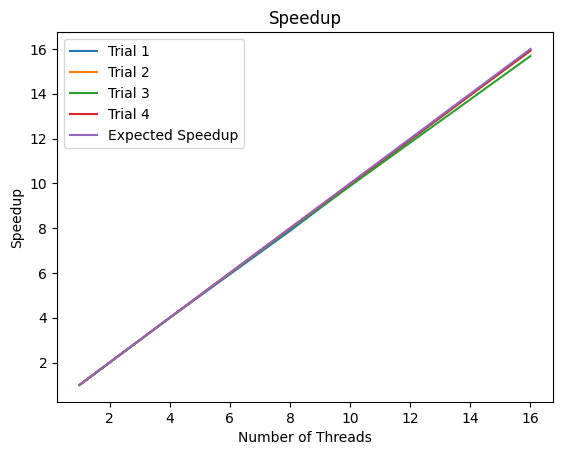

In [56]:
# Find all text files starting with "time"
fileListTime = glob.glob("time2*.txt")

# Get time data
ttArr, rrArr, uuArr = [], [], []
for fileName in fileListTime:
    with open(fileName, "r") as file:
        text = file.read().split("\n")
        text = [item for item in text if len(item) > 2]

    tt, rr, uu = [], [], []

    # Timing itself
    for item in text:
        item = item.split()
        tt += [int(item[5][:-1])]
        rr += [float(item[6])]

    ttArr += [tt]
    rrArr += [rr]
    uuArr += [uu]

ttArr = np.array(ttArr)
rrArr = np.array(rrArr)
uuArr = np.array(uuArr)

plt.title(f"Speedup")
for tt, rr, index in zip(ttArr, rrArr, range(0, len(ttArr))):
    plt.plot(tt, rr[0] / rr, label=f"Trial {index+1}")

plt.plot(tt, tt, label="Expected Speedup")
plt.xlabel("Number of Threads")
plt.ylabel("Speedup")
plt.legend()

# Question 3

In [57]:
def cheb(n: int, x: float | np.ndarray) -> float | np.ndarray:
    return np.cos(n * np.arccos(x))


# Find all text files starting with "out"
fileListData = glob.glob("out3*.txt")

# Array with the energy values
points = 800
ee = np.linspace(-1, 1, points)

# If all energy scales are the same, we can pre-compute the exact DOS
dosExactPre = dosThermo1D(ee * 4 * 1.01, 0.5, t1 = 0.5, t2 = 0.25)

# Organize the data into arrays
dataArr3 = []
dataDict3 = dict()
for file in fileListData:
    _, L0, L1, w, NAverages, Nmoments = file.split("-")
    L0, L1, w, NAverages, Nmoments = int(L0), float(L1), float(w), int(NAverages), int(Nmoments[:-4])
    
    # Load the file as an array of floats
    dataNum = np.genfromtxt(file, dtype=float)
    dataNum = dataNum.T

    # Clip for Chebyshev polynomials
    eecc = ee[1:-1]

    # Get chebyshev coeffcients
    mm = dataNum
    
    # Compute the DOS
    rho = np.zeros(len(eecc))
    rho = mm[0] * (1/np.pi) * 1 / np.sqrt(1 - eecc**2)
    for n in range(1, Nmoments):
        rho += mm[n] * (2/np.pi) * 1 / np.sqrt(1 - eecc**2) * cheb(n, eecc)
    
    # Rescale data
    energy_scale = (4 + w/2) * 1.01
    eedata = ee * energy_scale
    rho /= energy_scale

    # Store
    dataNum = [0] + list(rho) + [0]

    if w == 0:
        dataArr3 += [(L0, L1, w, NAverages, Nmoments, eedata, dataNum, dosExactPre)]
    else:
        dataDict3[w] = dataDict3.get(w, []) + [(L0, L1, w, NAverages, Nmoments, eedata, dataNum)]

In [58]:
def plotAll3(dataArr: list) -> None:
    # Needed number of columns
    for item in dataArr:
        # Getting data
        L0, L1, w, NAverages, Nmoments, eedata, dataNum, dataThermo = item

        # Plotting
        plt.title(f"Density of States for $L_0$ = {L0}, $L_1$ = {L1} and $w/t$ = {w} with {NAverages} Averages and {Nmoments} Moments")
        plt.plot(eedata, dataNum, label="Calculated DOS")
        plt.plot(eedata, dataThermo, label="Thermodynamic DOS")
        plt.xlabel("$\\varepsilon / t$")
        plt.ylabel("$\\rho(\\varepsilon) \\times t$")
        plt.legend()
        plt.show()

        # Analysis
        diff = dataNum - dataThermo
        print(f"Density of States for L0 = {L0}, L1 = {L1} and w/t = {w} with {NAverages} Averages and {Nmoments} Moments")
        print(f"Maximum difference is {np.max(np.abs(diff))}")
        print(f"Average difference is {np.mean(diff)}")
        print(f"Std of difference is {np.std(diff)}")
        print("\n\n")    

    plt.show() 

## Noiseless 1D System

First we run a simulation without noise to make sure our code is working as intended.

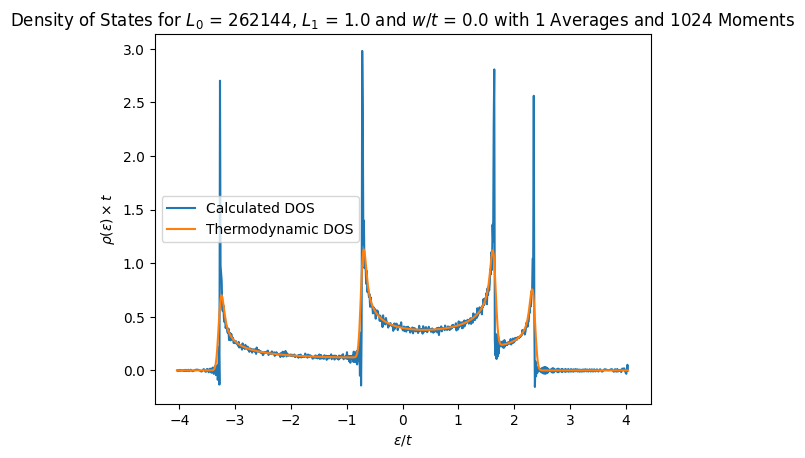

Density of States for L0 = 262144, L1 = 1.0 and w/t = 0.0 with 1 Averages and 1024 Moments
Maximum difference is 2.089066956519866
Average difference is -0.00022003241509939049
Std of difference is 0.17259267353355956





In [59]:
plotAll3(dataArr3)

## Noisy 2D System

We see that the increase in $L_1$ causes the peaks in the DOS of the system to get split into $L_1$ peaks of similar height.

This might be a consequence of level-repulsion between the bands associated with each of the rows in our strip.

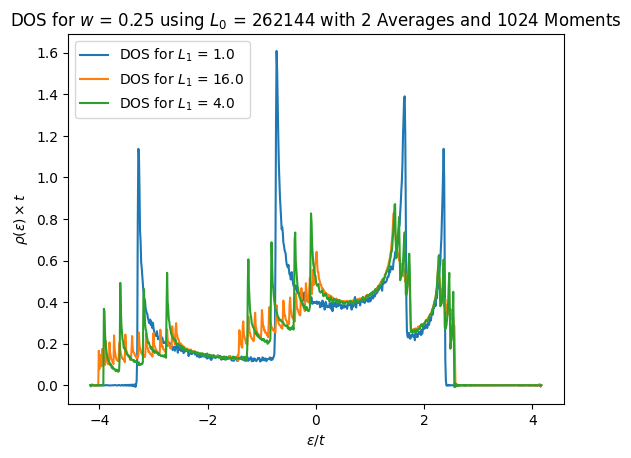

In [60]:
# Plot the system for fixed noise with different super cell dimensions
for w in [0.25]:
    dataArrLocal = dataDict3[w]

    for item in dataArrLocal:
        L0, L1, w, NAverages, Nmoments, eedata, dataNum = item
        plt.title(f"DOS for $w$ = {w} using $L_0$ = {L0} with {NAverages} Averages and {Nmoments} Moments")
        plt.plot(eedata, dataNum, label=f"DOS for $L_1$ = {L1}")
    
    plt.xlabel("$\\varepsilon / t$")
    plt.ylabel("$\\rho(\\varepsilon) \\times t$")
    plt.legend()
    plt.show()

# Question 4

## Question a)

### Question i)

### Question ii)

## Question b)

We start by trying to make the simulation without defects.

In [68]:
# Find all text files starting with "out"
fileListData = glob.glob("out4b*.txt")

# Organize the data into arrays
dataArr4 = []
for file in fileListData:
    _, L0, L1, NCheb = file.split("-")
    L0, L1, NCheb = int(L0), int(L1), int(NCheb[:-4])
    
    # Load the file as an array of strings
    data = np.loadtxt(file)
    dataArr4 += [(L0, L1, NCheb, data)]

With this aspect ratio, our gaussian becomes elongated along the vertical direction.

1024 20
(50, 1024, 40)


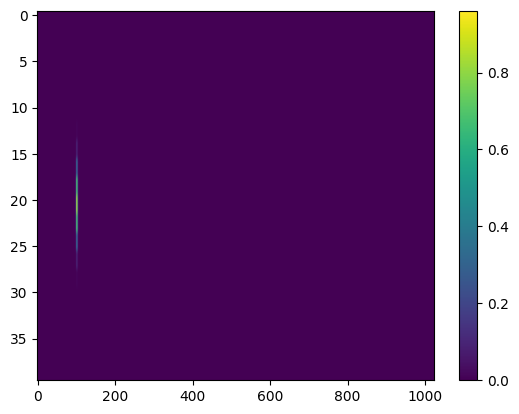

In [70]:
for item in dataArr4:
    L0, L1, NCheb, data = item
    timesteps = len(data[0, :])

    data = data**2

    print(L0, L1)

    dataProcessed = []
    for ti in range(timesteps):
        dataProcessed += [np.resize(data[:, ti], (L0, 2*L1))]
    dataProcessed = np.array(dataProcessed)

    print(dataProcessed.shape)

    plt.imshow(dataProcessed[0, :, :].T, aspect='auto')
    plt.colorbar()

In [64]:
# Imports
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image


#  Update rule for the video
timestep = 0
def update(frame, ax, dataProcessed):
    global timestep

    # Update time
    timestep += 1
    ax.set_title(f"Wave function at time step {timestep}.")

    # Update line data
    ax.imshow(dataProcessed[timestep, :, :].T, aspect='auto')

    return ax


# Make the video
def makeGIF(dataTuple: tuple, maxFrames: int = 100):
    global timestep

    # Extract the data
    L0, L1, NCheb, data = dataTuple
    data = data**2

    dataProcessed = []
    for ti in range(timesteps):
        dataProcessed += [np.resize(data[:, ti], (L0, 2*L1))]
    dataProcessed = np.array(dataProcessed)

    # Use only every skip item
    skip = int(len(dataProcessed[:, 0, 0]) / maxFrames + 1)
    dataProcessed = dataProcessed[0::skip, :, :]

    # Start the plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    # First frame
    ax.imshow(dataProcessed[0, :, :].T, aspect='auto')

    # Reset timestep
    timestep = 0

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(data[:, 0]), fargs=(ax, dataProcessed), interval=100)

    # Save animation
    ani.save(f"wave-{L0}-{L1}-{NCheb}.gif", writer="pillow")
    plt.close()

In [65]:
# makeGIF(dataArr4[0])